Returns head:
                 BND       SPY      TSLA
Date                                    
2015-01-05  0.002904 -0.018059 -0.042041
2015-01-06  0.002895 -0.009419  0.005664
2015-01-07  0.000602  0.012461 -0.001562
2015-01-08 -0.001563  0.017745 -0.001564
2015-01-09  0.001685 -0.008013 -0.018802
Backtesting period: 2025-01-13 00:00:00 to 2026-01-13 00:00:00
Number of rows: 252

Performance Metrics:
           Total Return  Annualized Return  Annualized Volatility  \
Strategy       0.168477           0.236992               0.403957   
Benchmark      0.161980           0.157731               0.118675   

           Sharpe Ratio  Max Drawdown  
Strategy       0.586676     -0.337556  
Benchmark      1.329093     -0.112888  


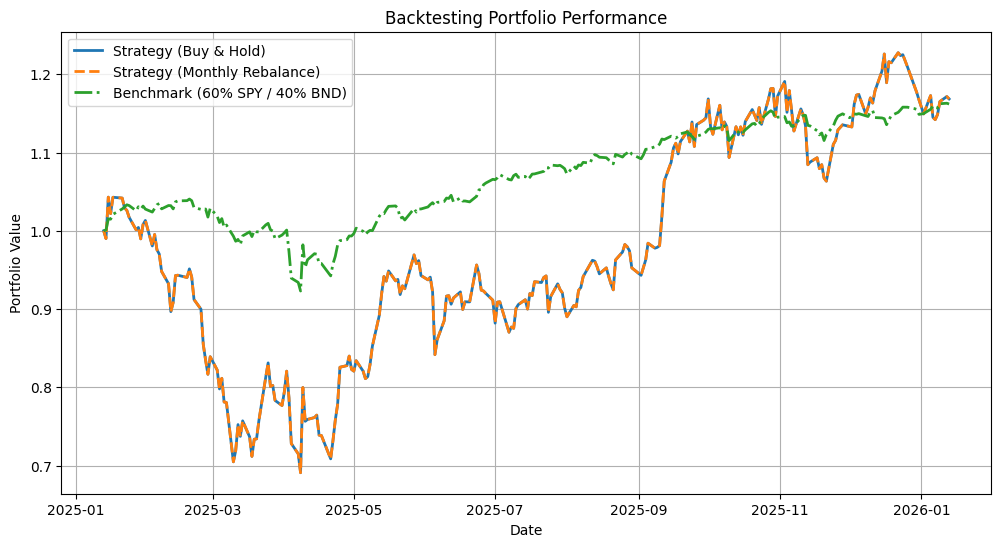

In [24]:
# -------------------------
# Task 5: Strategy Backtesting
# -------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1. Load Returns Data
# -------------------------
# Use processed returns from Task 1
returns = pd.read_csv("../data/processed/daily_returns.csv", index_col="Date", parse_dates=True)

# Verify
print("Returns head:")
print(returns.head())

# -------------------------
# 2. Define Backtesting Period
# -------------------------
start_date = "2025-01-13"
end_date = "2026-01-13"

returns_bt = returns.loc[start_date:end_date]
print(f"Backtesting period: {returns_bt.index.min()} to {returns_bt.index.max()}")
print(f"Number of rows: {len(returns_bt)}")

# -------------------------
# 3. Define Portfolios
# -------------------------

# Strategy portfolio weights (from Task 4 optimal weights)
weights_strategy = {
    "TSLA": 0.6,
    "BND": 0.2,
    "SPY": 0.2
}

# Benchmark portfolio: 60% SPY, 40% BND
weights_benchmark = {
    "TSLA": 0.0,
    "BND": 0.4,
    "SPY": 0.6
}

# -------------------------
# 4. Portfolio Simulation Function
# -------------------------
def simulate_portfolio(returns_df, weights, rebalance_freq=None):
    """
    Simulate portfolio cumulative returns.

    Args:
        returns_df (pd.DataFrame): daily returns
        weights (dict): asset weights
        rebalance_freq (str): None (buy & hold) or 'M' (monthly rebalance)
    Returns:
        portfolio_values, portfolio_returns (pd.Series)
    """
    portfolio_values = pd.Series(index=returns_df.index, dtype=float)
    portfolio_values.iloc[0] = 1.0  # initial value

    asset_order = returns_df.columns.tolist()
    weight_array = np.array([weights.get(asset, 0) for asset in asset_order])

    for i, date in enumerate(returns_df.index[1:], start=1):
        if rebalance_freq == "M" and date.month != returns_df.index[i-1].month:
            # Rebalance to original weights at month start
            weight_array = np.array([weights.get(asset, 0) for asset in asset_order])

        daily_return = np.dot(weight_array, returns_df.loc[date])
        portfolio_values.iloc[i] = portfolio_values.iloc[i-1] * (1 + daily_return)

    portfolio_returns = portfolio_values.pct_change().dropna()
    return portfolio_values, portfolio_returns

# -------------------------
# 5. Run Backtests
# -------------------------
strategy_bh_vals, strategy_bh_ret = simulate_portfolio(returns_bt, weights_strategy, rebalance_freq=None)
strategy_mr_vals, strategy_mr_ret = simulate_portfolio(returns_bt, weights_strategy, rebalance_freq="M")
benchmark_vals, benchmark_ret = simulate_portfolio(returns_bt, weights_benchmark, rebalance_freq=None)

# -------------------------
# 6. Compute Metrics
# -------------------------
def performance_metrics(portfolio_returns, portfolio_values):
    """
    Compute portfolio performance metrics.
    """
    total_ret = portfolio_values.iloc[-1] / portfolio_values.iloc[0] - 1
    ann_ret = portfolio_returns.mean() * 252
    ann_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol
    drawdown = (portfolio_values / portfolio_values.cummax() - 1).min()
    return pd.Series({
        "Total Return": total_ret,
        "Annualized Return": ann_ret,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": drawdown
    })


metrics_strategy = performance_metrics(strategy_bh_ret, strategy_bh_vals)
metrics_benchmark = performance_metrics(benchmark_ret, benchmark_vals)

metrics_df = pd.DataFrame({
    "Strategy": metrics_strategy,
    "Benchmark": metrics_benchmark
}).T

print("\nPerformance Metrics:")
print(metrics_df)

# -------------------------
# 7. Plot Cumulative Returns
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(strategy_bh_vals, label="Strategy (Buy & Hold)", linewidth=2)
plt.plot(strategy_mr_vals, label="Strategy (Monthly Rebalance)", linewidth=2, linestyle="--")
plt.plot(benchmark_vals, label="Benchmark (60% SPY / 40% BND)", linewidth=2, linestyle="-.")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Backtesting Portfolio Performance")
plt.legend()
plt.grid(True)
plt.show()
